# Tutorial: optimal binning with continuous target

## Basic

To get us started, let's load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston

In [2]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the continuous target.

In [3]:
variable = "LSTAT"
x = df[variable].values
y = data.target

Import and instantiate an ``ContinuousOptimalBinning`` object class. We pass the variable name and its data type.

In [4]:
from optbinning import ContinuousOptimalBinning

In [5]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical")

We fit the optimal binning object with arrays ``x`` and ``y``.

In [6]:
optb.fit(x, y)

ContinuousOptimalBinning(cat_cutoff=None, dtype='numerical', max_bin_size=None,
                         max_n_bins=None, max_n_prebins=20, max_pvalue=None,
                         max_pvalue_policy='consecutive', min_bin_size=None,
                         min_mean_diff=0, min_n_bins=None, min_prebin_size=0.05,
                         monotonic_trend='auto', name='LSTAT',
                         outlier_detector=None, outlier_params=None,
                         prebinning_method='cart', special_codes=None,
                         split_digits=None, time_limit=100, user_splits=None,
                         user_splits_fixed=None, verbose=False)

You can check if an optimal solution has been found via the ``status`` attribute:

In [7]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [8]:
optb.splits

array([ 4.6500001 ,  5.49499989,  6.86500001,  9.7249999 , 11.67499971,
       13.0999999 , 16.08500004, 19.89999962, 23.31500053])

#### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``ContinuousOptimalBinning`` returns an object ``ContinuousBinningTable`` via the ``binning_table`` attribute.

In [9]:
binning_table = optb.binning_table

In [10]:
type(binning_table)

optbinning.binning.binning_statistics.ContinuousBinningTable

The `binning_table` is instantiated, but not built. Therefore, the first step is to call the method `build`, which returns a ``pandas.DataFrame``.

In [11]:
binning_table.build()

,Bin,Count,Count (%),Sum,Mean,Min,Max,Zeros count,WoE,IV
0,"[-inf, 4.65)",50,0.098814,1985.9,39.718000,22.8,50.0,0,17.1852,1.698142
1,"[4.65, 5.49)",28,0.055336,853.2,30.471429,21.9,50.0,0,7.93862,0.439291
2,"[5.49, 6.87)",45,0.088933,1188.6,26.413333,20.6,48.8,0,3.88053,0.345106
3,"[6.87, 9.72)",89,0.175889,2274.9,25.560674,11.9,50.0,0,3.02787,0.532570
4,"[9.72, 11.67)",49,0.096838,1057.9,21.589796,15.0,31.0,0,-0.94301,0.091319
5,"[11.67, 13.10)",35,0.069170,697.5,19.928571,14.5,27.9,0,-2.60423,0.180135
6,"[13.10, 16.09)",66,0.130435,1289.9,19.543939,10.2,30.7,0,-2.98887,0.389852
7,"[16.09, 19.90)",69,0.136364,1129.3,16.366667,8.3,27.5,0,-6.16614,0.840837
8,"[19.90, 23.32)",28,0.055336,368.4,13.157143,5.0,21.7,0,-9.37566,0.518811
9,"[23.32, inf)",47,0.092885,556.0,11.829787,5.0,23.7,0,-10.703,0.994154


Let's describe the columns of this binning table:

- Bin: the intervals delimited by the optimal split points.
- Count: the number of records for each bin.
- Count (%): the percentage of records for each bin.
- Sum: the target sum for each bin.
- Mean: the target mean for each bin.

The last row shows the total number of records, sum and mean.

You can use the method ``plot`` to visualize the histogram and mean curve. Note that the Bin ID corresponds to the binning table index.

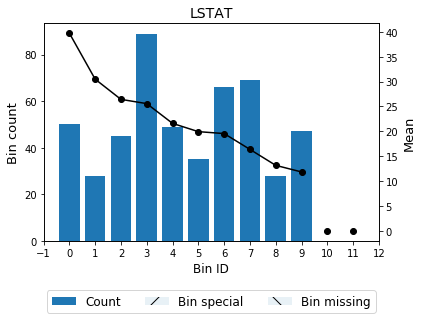

In [12]:
binning_table.plot()

##### Mean transformation

Now that we have checked the binned data, we can transform our original data into mean values. You can check the correctness of the transformation using pandas ``value_counts`` method, for instance.

In [13]:
x_transform_mean = optb.transform(x, metric="bins")

In [14]:
pd.Series(x_transform_mean).value_counts()

[6.87, 9.72)      89
[16.09, 19.90)    69
[13.10, 16.09)    66
[-inf, 4.65)      50
[9.72, 11.67)     49
[23.32, inf)      47
[5.49, 6.87)      45
[11.67, 13.10)    35
[4.65, 5.49)      28
[19.90, 23.32)    28
dtype: int64

## Advanced

Many of the advanced options have been covered in the previous tutorials with a binary target. **Check it out!** In this section, we focus on the mean monotonicity trend and the mean difference between bins.

#### Binning table statistical analysis

The ``analysis`` method performs a statistical analysis of the binning table, computing the Information Value (IV) and Herfindahl-Hirschman Index (HHI).

In [15]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       6.03021763
    HHI                      0.11313253
    HHI (normalized)         0.03250821

  Monotonic trend            descending



#### Mean monotonicity

The monotonic_trend option permits forcing a monotonic trend to the mean curve. The default setting “auto” should be the preferred option, however, some business constraints might require to impose different trends. The default setting “auto” chooses the monotonic trend most likely to minimize the L1-norm from the options “ascending”, “descending”, “peak” and “valley” using a machine-learning-based classifier.

In [16]:
variable = "INDUS"
x = df[variable].values
y = data.target

In [17]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="auto")
optb.fit(x, y)

ContinuousOptimalBinning(cat_cutoff=None, dtype='numerical', max_bin_size=None,
                         max_n_bins=None, max_n_prebins=20, max_pvalue=None,
                         max_pvalue_policy='consecutive', min_bin_size=None,
                         min_mean_diff=0, min_n_bins=None, min_prebin_size=0.05,
                         monotonic_trend='auto', name='INDUS',
                         outlier_detector=None, outlier_params=None,
                         prebinning_method='cart', special_codes=None,
                         split_digits=None, time_limit=100, user_splits=None,
                         user_splits_fixed=None, verbose=False)

In [18]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Mean,Min,Max,Zeros count,WoE,IV
0,"[-inf, 3.35)",63,0.124506,1994.0,31.650794,16.5,50.0,0,9.11799,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,28.336842,17.2,50.0,0,5.80404,0.653814
2,"[5.04, 6.66)",66,0.130435,1723.7,26.116667,16.0,50.0,0,3.58386,0.467460
3,"[6.66, 8.01)",31,0.061265,692.0,22.322581,14.4,35.2,0,-0.210226,0.012879
4,"[8.01, 16.57)",100,0.197628,2045.5,20.455000,11.9,28.7,0,-2.07781,0.410634
5,"[16.57, 18.84)",132,0.260870,2165.3,16.403788,5.0,50.0,0,-6.12902,1.598874
6,"[18.84, inf)",57,0.112648,1165.9,20.454386,7.0,50.0,0,-2.07842,0.234130
7,Special,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
8,Missing,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
Totals,,506,1.000000,11401.6,22.532806,NaN,NaN,0,,4.513036


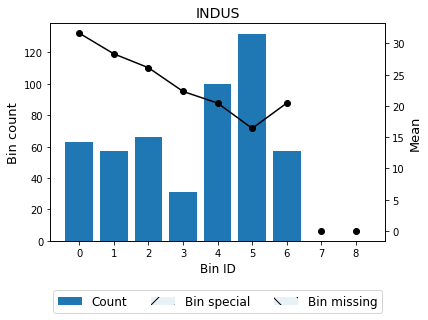

In [19]:
binning_table.plot()

In [20]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.51303567
    HHI                      0.16875752
    HHI (normalized)         0.06485221

  Monotonic trend                valley



A smoother curve, keeping the valley monotonicity, can be achieved by using ``monotonic_trend="convex"``.

In [21]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="convex")
optb.fit(x, y)

ContinuousOptimalBinning(cat_cutoff=None, dtype='numerical', max_bin_size=None,
                         max_n_bins=None, max_n_prebins=20, max_pvalue=None,
                         max_pvalue_policy='consecutive', min_bin_size=None,
                         min_mean_diff=0, min_n_bins=None, min_prebin_size=0.05,
                         monotonic_trend='convex', name='INDUS',
                         outlier_detector=None, outlier_params=None,
                         prebinning_method='cart', special_codes=None,
                         split_digits=None, time_limit=100, user_splits=None,
                         user_splits_fixed=None, verbose=False)

In [22]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Mean,Min,Max,Zeros count,WoE,IV
0,"[-inf, 3.99)",92,0.181818,2932.6,31.876087,16.5,50.0,0,9.34328,1.698778
1,"[3.99, 5.04)",28,0.055336,676.6,24.164286,17.2,37.3,0,1.63148,0.090279
2,"[5.04, 6.08)",40,0.079051,878.6,21.965000,16.0,42.8,0,-0.567806,0.044886
3,"[6.08, 18.84)",289,0.571146,5747.9,19.888927,5.0,50.0,0,-2.64388,1.510042
4,"[18.84, inf)",57,0.112648,1165.9,20.454386,7.0,50.0,0,-2.07842,0.234130
5,Special,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
6,Missing,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
Totals,,506,1.000000,11401.6,22.532806,NaN,NaN,0,,3.578116


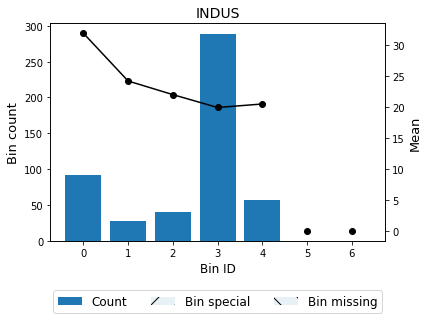

In [23]:
binning_table.plot()

In [24]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       3.57811558
    HHI                      0.38126670
    HHI (normalized)         0.27814448

  Monotonic trend       valley (convex)



For example, we can force the variable INDUS (proportion of non-retail business acres per town) to be monotonically descending with respect to the house-price.

In [25]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending")
optb.fit(x, y)

ContinuousOptimalBinning(cat_cutoff=None, dtype='numerical', max_bin_size=None,
                         max_n_bins=None, max_n_prebins=20, max_pvalue=None,
                         max_pvalue_policy='consecutive', min_bin_size=None,
                         min_mean_diff=0, min_n_bins=None, min_prebin_size=0.05,
                         monotonic_trend='descending', name='INDUS',
                         outlier_detector=None, outlier_params=None,
                         prebinning_method='cart', special_codes=None,
                         split_digits=None, time_limit=100, user_splits=None,
                         user_splits_fixed=None, verbose=False)

In [26]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Mean,Min,Max,Zeros count,WoE,IV
0,"[-inf, 3.35)",63,0.124506,1994.0,31.650794,16.5,50.0,0,9.11799,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,28.336842,17.2,50.0,0,5.80404,0.653814
2,"[5.04, 6.66)",66,0.130435,1723.7,26.116667,16.0,50.0,0,3.58386,0.467460
3,"[6.66, 8.01)",31,0.061265,692.0,22.322581,14.4,35.2,0,-0.210226,0.012879
4,"[8.01, 16.57)",100,0.197628,2045.5,20.455000,11.9,28.7,0,-2.07781,0.410634
5,"[16.57, 20.73)",162,0.320158,2874.8,17.745679,5.0,50.0,0,-4.78713,1.532638
6,"[20.73, inf)",27,0.053360,456.4,16.903704,7.0,23.0,0,-5.6291,0.300367
7,Special,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
8,Missing,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
Totals,,506,1.000000,11401.6,22.532806,NaN,NaN,0,,4.513036


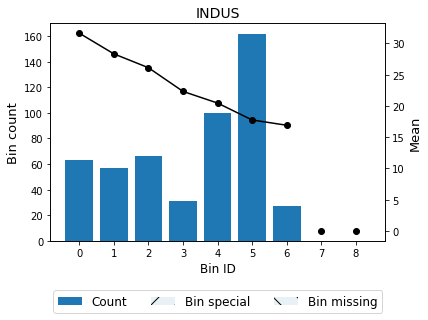

In [27]:
binning_table.plot()

In [28]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.51303567
    HHI                      0.19336343
    HHI (normalized)         0.09253386

  Monotonic trend            descending



#### Mininum mean difference between consecutive bins

Now, we note that the mean difference between consecutive bins is not significant enough. Therefore, we decide to set ``min_mean_diff=2.0``:

In [29]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending", min_mean_diff=2.0)
optb.fit(x, y)

ContinuousOptimalBinning(cat_cutoff=None, dtype='numerical', max_bin_size=None,
                         max_n_bins=None, max_n_prebins=20, max_pvalue=None,
                         max_pvalue_policy='consecutive', min_bin_size=None,
                         min_mean_diff=2.0, min_n_bins=None,
                         min_prebin_size=0.05, monotonic_trend='descending',
                         name='INDUS', outlier_detector=None,
                         outlier_params=None, prebinning_method='cart',
                         special_codes=None, split_digits=None, time_limit=100,
                         user_splits=None, user_splits_fixed=None,
                         verbose=False)

In [30]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Mean,Min,Max,Zeros count,WoE,IV
0,"[-inf, 3.35)",63,0.124506,1994.0,31.650794,16.5,50.0,0,9.11799,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,28.336842,17.2,50.0,0,5.80404,0.653814
2,"[5.04, 6.66)",66,0.130435,1723.7,26.116667,16.0,50.0,0,3.58386,0.467460
3,"[6.66, 16.57)",131,0.258893,2737.5,20.896947,11.9,35.2,0,-1.63586,0.423513
4,"[16.57, inf)",189,0.373518,3331.2,17.625397,5.0,50.0,0,-4.90741,1.833005
5,Special,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
6,Missing,0,0.000000,0.0,0.000000,NaN,NaN,0,-22.5328,0.000000
Totals,,506,1.000000,11401.6,22.532806,NaN,NaN,0,,4.513036


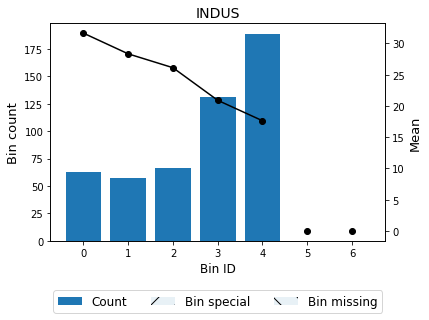

In [31]:
binning_table.plot()

In [32]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.51303567
    HHI                      0.25174585
    HHI (normalized)         0.12703682

  Monotonic trend            descending

